In [1]:
# import tensorflow as tf
# import numpy as np

# # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
# # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# # tf.config.gpu.set_per_process_memory_fraction(0.25)
# # tf.config.gpu.set_per_process_memory_growth(True)

# # config = tf.compat.v1.ConfigProto()
# # config.gpu_options.allow_growth=True
# # sess = tf.compat.v1.Session(config=config)

# config = tf.compat.v1.ConfigProto()
# # config.gpu_options.per_process_gpu_memory_fraction = 0.4
# config.gpu_options.allow_growth=True
# session = tf.compat.v1.Session(config=config)

# # tf.config.gpu.set_per_process_memory_growth(True)
# # tf.config.experimental.set_virtual_device_configuration(0.25)

In [2]:
from tensorflow.python.client import device_lib
import numpy as np

print(device_lib.list_local_devices())

2022-08-21 20:31:43.177288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 61113709632271693
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7315640832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4070359008398589535
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
]


2022-08-21 20:31:44.130078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 20:31:44.130462: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-21 20:31:44.131167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-21 20:31:44.198346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 20:31:44.198770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 na

In [3]:
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified
        as working)
 
 To run the EEG/MEG ERP classification sample script, you will also need

    (4) mne >= 0.17.1
    (5) PyRiemann >= 0.2.5
    (6) scikit-learn >= 0.20.1
    (7) matplotlib >= 2.2.3
    
 To use:
    
    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as
        
        from EEGModels import EEGNet    
        
        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)
        
    (3) Then compile and fit the model
    
        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)

 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 
"""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)




def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)



def EEGNet_old(nb_classes, Chans = 64, Samples = 128, regRate = 0.0001,
           dropoutRate = 0.25, kernels = [(2, 32), (8, 4)], strides = (2, 4)):
    """ Keras Implementation of EEGNet_v1 (https://arxiv.org/abs/1611.08024v2)

    This model is the original EEGNet model proposed on arxiv
            https://arxiv.org/abs/1611.08024v2
    
    with a few modifications: we use striding instead of max-pooling as this 
    helped slightly in classification performance while also providing a 
    computational speed-up. 
    
    Note that we no longer recommend the use of this architecture, as the new
    version of EEGNet performs much better overall and has nicer properties.
    
    Inputs:
        
        nb_classes     : total number of final categories
        Chans, Samples : number of EEG channels and samples, respectively
        regRate        : regularization rate for L1 and L2 regularizations
        dropoutRate    : dropout fraction
        kernels        : the 2nd and 3rd layer kernel dimensions (default is 
                         the [2, 32] x [8, 4] configuration)
        strides        : the stride size (note that this replaces the max-pool
                         used in the original paper)
    
    """

    # start the model
    input_main   = Input(shape = (Chans, Samples, 1))
    layer1       = Conv2D(16, (Chans, 1), input_shape=(Chans, Samples, 1),
                                 kernel_regularizer = l1_l2(l1=regRate, l2=regRate))(input_main)
    layer1       = BatchNormalization()(layer1)
    layer1       = Activation('elu')(layer1)
    layer1       = Dropout(dropoutRate)(layer1)
    
    permute_dims = 2, 1, 3
    permute1     = Permute(permute_dims)(layer1)
    
    layer2       = Conv2D(4, kernels[0], padding = 'same', 
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(permute1)
    layer2       = BatchNormalization()(layer2)
    layer2       = Activation('elu')(layer2)
    layer2       = Dropout(dropoutRate)(layer2)
    
    layer3       = Conv2D(4, kernels[1], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(layer2)
    layer3       = BatchNormalization()(layer3)
    layer3       = Activation('elu')(layer3)
    layer3       = Dropout(dropoutRate)(layer3)
    
    flatten      = Flatten(name = 'flatten')(layer3)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



In [4]:
import sys

lag = 10 #int(str(sys.argv[1]))
print(lag)

10


In [5]:
nmed_chan = [2,3,5,8,10,12,14,18,21,22,23,26,27,28,29,32,33,35,36,40,41,45,46,50,51,54,57,59,61,64,66,69,71,74,76,82,84,86,89,91,92,95,96,97,101,102,103,104,110,111,115,116,121,122,123]
seed_chan = list(range(23)) + list(range(24,27)) + list(range(28,31)) + list(range(32,51)) + list(range(52,55))+[56] + list(range(58,61))
med_chan = [0] + list(range(2,14)) + list(range(15,23)) + list(range(24,27)) + list(range(28,34)) + [35] + list(range(37,47)) + list(range(48,51)) + list(range(52,60)) + list(range(61,64))

In [6]:
x = []
y = []
x_test = []
y_test = []
z = 55*lag

In [7]:
from scipy.io import loadmat

mat_contents = loadmat('song21_Imputed.mat')
data = mat_contents['data21']
print(data.shape)
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song22_Imputed.mat')
data = mat_contents['data22']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song24_Imputed.mat')
data = mat_contents['data24']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song25_Imputed.mat')
data = mat_contents['data25']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song27_Imputed.mat')
data = mat_contents['data27']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song28_Imputed.mat')
data = mat_contents['data28']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])
        
mat_contents = loadmat('song30_Imputed.mat')
data = mat_contents['data30']
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(12):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,0])

(125, 34795, 20)
(55, 34795, 20)
(125, 33891, 20)
(55, 33891, 20)
(125, 36797, 20)
(55, 36797, 20)
(125, 36114, 20)
(55, 36114, 20)
(125, 36454, 20)
(55, 36454, 20)
(125, 36513, 20)
(55, 36513, 20)
(125, 37221, 20)
(55, 37221, 20)


In [8]:
mat_contents = loadmat('song23_Imputed.mat')
data = mat_contents['data23']
print(data.shape)
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
data1 = np.array(data1)
print(data1.shape)
for idx in range(12,20):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,0])
        
mat_contents = loadmat('song26_Imputed.mat')
data = mat_contents['data26']
print(data.shape)
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
data1 = np.array(data1)
print(data1.shape)
for idx in range(12,20):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,0])
        
mat_contents = loadmat('song29_Imputed.mat')
data = mat_contents['data29']
print(data.shape)
data1 = []
for i in nmed_chan:
    data1.append(data[i,:,:])
data1 = np.array(data1)
print(data1.shape)
for idx in range(12,20):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,0])

(125, 34469, 20)
(55, 34469, 20)
(125, 34478, 20)
(55, 34478, 20)
(125, 36712, 20)
(55, 36712, 20)


In [9]:
print(len(x))
print(len(x_test))
print(len(y))
print(len(y_test))

5448
1520
5448
1520


In [10]:
mat_contents = loadmat('SEED/stim_101.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_102.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_104.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_105.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_107.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_108.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_110.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_111.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_113.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])
        
mat_contents = loadmat('SEED/stim_114.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,1])

(62, 47001, 15)
(55, 47001, 15)
(62, 46601, 15)
(55, 46601, 15)
(62, 47601, 15)
(55, 47601, 15)
(62, 37001, 15)
(55, 37001, 15)
(62, 47401, 15)
(55, 47401, 15)
(62, 43201, 15)
(55, 43201, 15)
(62, 47401, 15)
(55, 47401, 15)
(62, 47001, 15)
(55, 47001, 15)
(62, 47001, 15)
(55, 47001, 15)
(62, 47601, 15)
(55, 47601, 15)


In [11]:
mat_contents = loadmat('SEED/stim_103.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10,15):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,1])

mat_contents = loadmat('SEED/stim_106.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10,15):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,1])

mat_contents = loadmat('SEED/stim_109.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10,15):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,1])

mat_contents = loadmat('SEED/stim_112.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10,15):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,1])

mat_contents = loadmat('SEED/stim_115.mat')
data = mat_contents['data']
data1 = []
for i in seed_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(10,15):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,1])

(62, 41201, 15)
(55, 41201, 15)
(62, 39001, 15)
(55, 39001, 15)
(62, 53001, 15)
(55, 53001, 15)
(62, 46601, 15)
(55, 46601, 15)
(62, 41201, 15)
(55, 41201, 15)


In [12]:
print(len(x))
print(len(x_test))
print(len(y))
print(len(y_test))

13728
3510
13728
3510


In [13]:
mat_contents = loadmat('VIP_md.mat')
data = mat_contents['VIP_md']
data1 = []
for i in med_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(16):
    for i in range(0,len(data1[0])-z,z):
        x.append(data1[:,i:i+(z),idx])
        y.append([idx,2])
        
mat_contents = loadmat('HT_md.mat')
data = mat_contents['HT_md']
data1 = []
for i in med_chan:
    data1.append(data[i,:,:])
print(data.shape)
data1 = np.array(data1)
print(data1.shape)
for idx in range(16):
    for i in range(0,len(data1[0])-z,z):
        x_test.append(data1[:,i:i+(z),idx])
        y_test.append([idx,2])

(64, 104960, 16)
(55, 104960, 16)
(64, 104192, 16)
(55, 104192, 16)


In [14]:
print(len(x))
print(len(x_test))
print(len(y))
print(len(y_test))

16768
6534
16768
6534


In [15]:
y = np.array(y)
x =np.array(x)
print(x.shape)
print(y.shape)

(16768, 55, 550)
(16768, 2)


In [16]:
y_test = np.array(y_test)
X_test =np.array(x_test)
print(X_test.shape)
print(y_test.shape)

(6534, 55, 550)
(6534, 2)


In [17]:
set(y[:,0])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [18]:
set(y[:,1])

{0, 1, 2}

### without scaling

(16768, 55, 550)
(16768, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-21 20:32:48.093692: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-21 20:32:48.093871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 20:32:48.094340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-21 20:32:48.094365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-21 20:32:48.094388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 20:32:48.094397: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-21 20:32:50.218781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 20:32:50.373231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


420/420 - 6s - loss: 0.4149 - accuracy: 0.8611 - val_loss: 1.7852 - val_accuracy: 0.3277

Epoch 00001: val_loss improved from inf to 1.78524, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
420/420 - 4s - loss: 0.1165 - accuracy: 0.9755 - val_loss: 1.9997 - val_accuracy: 0.3360

Epoch 00002: val_loss did not improve from 1.78524
Epoch 3/100
420/420 - 4s - loss: 0.0705 - accuracy: 0.9860 - val_loss: 1.7249 - val_accuracy: 0.3435

Epoch 00003: val_loss improved from 1.78524 to 1.72493, saving model to /tmp/checkpoint_0001.h5
Epoch 4/100
420/420 - 4s - loss: 0.0437 - accuracy: 0.9928 - val_loss: 1.0439 - val_accuracy: 0.4114

Epoch 00004: val_loss improved from 1.72493 to 1.04393, saving model to /tmp/checkpoint_0001.h5
Epoch 5/100
420/420 - 4s - loss: 0.0270 - accuracy: 0.9972 - val_loss: 1.1371 - val_accuracy: 0.4356

Epoch 00005: val_loss did not improve from 1.04393
Epoch 6/100
420/420 - 4s - loss: 0.0261 - accuracy: 0.9963 - val_loss: 2.3949 - val_accuracy: 0.3479

Epoch 00006: v

<AxesSubplot:title={'center':'EEGNet Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

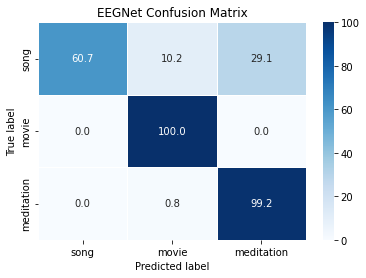

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = EEGNet(nb_classes = 3, Chans = chans, Samples = samples, 
                           dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet Confusion Matrix')

(16768, 55, 550)
(16768, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-21 19:42:58.692298: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-21 19:42:58.692475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 19:42:58.692924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-21 19:42:58.692949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-21 19:42:58.692972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 19:42:58.692981: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-21 19:43:00.788698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 19:43:00.940668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


420/420 - 5s - loss: 0.4268 - accuracy: 0.8111 - val_loss: 1.9428 - val_accuracy: 0.3828

Epoch 00001: val_loss improved from inf to 1.94279, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
420/420 - 3s - loss: 0.0471 - accuracy: 0.9853 - val_loss: 2.2078 - val_accuracy: 0.4120

Epoch 00002: val_loss did not improve from 1.94279
Epoch 3/100
420/420 - 3s - loss: 0.0315 - accuracy: 0.9902 - val_loss: 3.2940 - val_accuracy: 0.3629

Epoch 00003: val_loss did not improve from 1.94279
Epoch 4/100
420/420 - 3s - loss: 0.0292 - accuracy: 0.9900 - val_loss: 2.0047 - val_accuracy: 0.4809

Epoch 00004: val_loss did not improve from 1.94279
Epoch 5/100
420/420 - 3s - loss: 0.0126 - accuracy: 0.9958 - val_loss: 3.4536 - val_accuracy: 0.3855

Epoch 00005: val_loss did not improve from 1.94279
Epoch 6/100
420/420 - 3s - loss: 0.0155 - accuracy: 0.9958 - val_loss: 3.2916 - val_accuracy: 0.3858

Epoch 00006: val_loss did not improve from 1.94279
Epoch 7/100
420/420 - 3s - loss: 0.0102 - accuracy: 0

<AxesSubplot:title={'center':'EEGNet_SSVEP Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

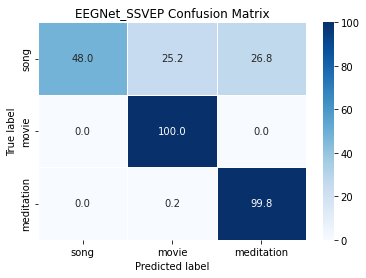

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = EEGNet_SSVEP(nb_classes = 3, Chans = chans, Samples = samples,
                                 dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet_SSVEP Confusion Matrix')

(16768, 55, 550)
(16768, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-21 19:50:45.769889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-21 19:50:45.770068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 19:50:45.770528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-21 19:50:45.770553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-21 19:50:45.770576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 19:50:45.770585: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-21 19:50:48.097627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-21 19:50:48.250968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


420/420 - 6s - loss: 0.1055 - accuracy: 0.9576 - val_loss: 0.8925 - val_accuracy: 0.7490

Epoch 00001: val_loss improved from inf to 0.89250, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
420/420 - 4s - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.3106 - val_accuracy: 0.8936

Epoch 00002: val_loss improved from 0.89250 to 0.31057, saving model to /tmp/checkpoint_0001.h5
Epoch 3/100
420/420 - 4s - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.9020 - val_accuracy: 0.7531

Epoch 00003: val_loss did not improve from 0.31057
Epoch 4/100
420/420 - 4s - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.3477 - val_accuracy: 0.8864

Epoch 00004: val_loss did not improve from 0.31057
Epoch 5/100
420/420 - 4s - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.1881 - val_accuracy: 0.9362

Epoch 00005: val_loss improved from 0.31057 to 0.18807, saving model to /tmp/checkpoint_0001.h5
Epoch 6/100
420/420 - 4s - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.0883 - val_accuracy: 0.9711

Epoch 00006: v

<AxesSubplot:title={'center':'DeepConvNet Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

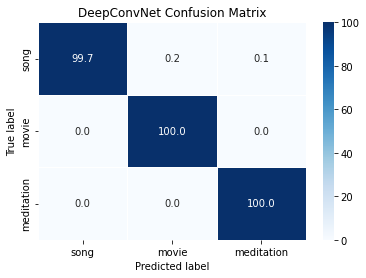

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = DeepConvNet(nb_classes = 3, Chans = chans, Samples = samples, dropoutRate = 0.5)

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'DeepConvNet Confusion Matrix')

### Scaling

In [19]:
######### For standardizing
import mne
x = mne.decoding.Scaler(scalings='mean').fit_transform(epochs_data=x, y=None)
X_test = mne.decoding.Scaler(scalings='mean').fit_transform(epochs_data=X_test, y=None)
print(x.shape)
print(X_test.shape)

(15860, 55, 550)
(5964, 55, 550)


(15860, 55, 550)
(15860, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-20 23:51:58.798023: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 23:51:58.798204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 23:51:58.798655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-20 23:51:58.798680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-20 23:51:58.798703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:51:58.798712: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-20 23:52:01.121336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:52:01.273531: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


397/397 - 6s - loss: 0.0850 - accuracy: 0.9677 - val_loss: 1.6952 - val_accuracy: 0.6176

Epoch 00001: val_loss improved from inf to 1.69518, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
397/397 - 3s - loss: 0.0092 - accuracy: 0.9972 - val_loss: 1.4419 - val_accuracy: 0.6460

Epoch 00002: val_loss improved from 1.69518 to 1.44185, saving model to /tmp/checkpoint_0001.h5
Epoch 3/100
397/397 - 3s - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.7618 - val_accuracy: 0.8424

Epoch 00003: val_loss improved from 1.44185 to 0.76178, saving model to /tmp/checkpoint_0001.h5
Epoch 4/100
397/397 - 3s - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.1542 - val_accuracy: 0.9442

Epoch 00004: val_loss improved from 0.76178 to 0.15421, saving model to /tmp/checkpoint_0001.h5
Epoch 5/100
397/397 - 3s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1937 - val_accuracy: 0.9344

Epoch 00005: val_loss did not improve from 0.15421
Epoch 6/100
397/397 - 3s - loss: 7.6719e-04 - accuracy: 0.9999 - val_lo

<AxesSubplot:title={'center':'ConfusionMatrix'}, xlabel='Predicted label', ylabel='True label'>

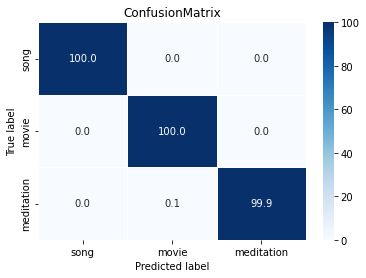

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = DeepConvNet(nb_classes = 3, Chans = chans, Samples = samples, dropoutRate = 0.5)

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'ConfusionMatrix')

(15860, 55, 550)
(15860, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-20 23:44:27.044899: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 23:44:27.045078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 23:44:27.045527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-20 23:44:27.045552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-20 23:44:27.045575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:44:27.045585: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-20 23:44:29.182733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:44:29.339085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


397/397 - 5s - loss: 0.2419 - accuracy: 0.9014 - val_loss: 0.1228 - val_accuracy: 0.9511

Epoch 00001: val_loss improved from inf to 0.12284, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
397/397 - 3s - loss: 0.0208 - accuracy: 0.9951 - val_loss: 0.0198 - val_accuracy: 0.9918

Epoch 00002: val_loss improved from 0.12284 to 0.01980, saving model to /tmp/checkpoint_0001.h5
Epoch 3/100
397/397 - 3s - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0014 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.01980 to 0.00140, saving model to /tmp/checkpoint_0001.h5
Epoch 4/100
397/397 - 3s - loss: 0.0087 - accuracy: 0.9977 - val_loss: 8.5348e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00140 to 0.00085, saving model to /tmp/checkpoint_0001.h5
Epoch 5/100
397/397 - 3s - loss: 0.0049 - accuracy: 0.9981 - val_loss: 6.5544e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss improved from 0.00085 to 0.00066, saving model to /tmp/checkpoint_0001.h5
Epoch 6/100
397/39

<AxesSubplot:title={'center':'ConfusionMatrix'}, xlabel='Predicted label', ylabel='True label'>

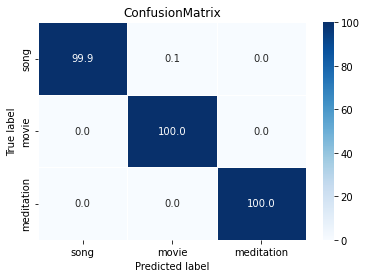

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = EEGNet_SSVEP(nb_classes = 3, Chans = chans, Samples = samples,
                                 dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'ConfusionMatrix')

(15860, 55, 550)
(15860, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2}


2022-08-20 23:35:51.381743: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 23:35:51.381920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 23:35:51.382370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-20 23:35:51.382394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-20 23:35:51.382417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:35:51.382427: I tensorflow/stream_executor/platform/

Epoch 1/100


2022-08-20 23:35:53.502766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-20 23:35:53.654191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


397/397 - 6s - loss: 0.3212 - accuracy: 0.9180 - val_loss: 0.1441 - val_accuracy: 0.9694

Epoch 00001: val_loss improved from inf to 0.14414, saving model to /tmp/checkpoint_0001.h5
Epoch 2/100
397/397 - 3s - loss: 0.0700 - accuracy: 0.9928 - val_loss: 0.0309 - val_accuracy: 0.9997

Epoch 00002: val_loss improved from 0.14414 to 0.03091, saving model to /tmp/checkpoint_0001.h5
Epoch 3/100
397/397 - 3s - loss: 0.0434 - accuracy: 0.9966 - val_loss: 0.0235 - val_accuracy: 0.9994

Epoch 00003: val_loss improved from 0.03091 to 0.02346, saving model to /tmp/checkpoint_0001.h5
Epoch 4/100
397/397 - 3s - loss: 0.0279 - accuracy: 0.9983 - val_loss: 0.0114 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.02346 to 0.01137, saving model to /tmp/checkpoint_0001.h5
Epoch 5/100
397/397 - 3s - loss: 0.0252 - accuracy: 0.9972 - val_loss: 0.0189 - val_accuracy: 0.9978

Epoch 00005: val_loss did not improve from 0.01137
Epoch 6/100
397/397 - 3s - loss: 0.0142 - accuracy: 0.9994 - val_loss: 

<AxesSubplot:title={'center':'ConfusionMatrix'}, xlabel='Predicted label', ylabel='True label'>

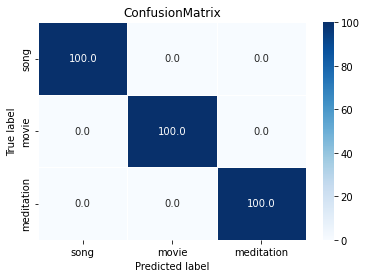

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from pyriemann.utils.viz import plot_confusion_matrix
import pandas as pd

chans = x.shape[1]
samples = x.shape[2]
kernels = 1
print(x.shape)
print(y.shape)
print(set(y[:,0]))
print(set(y[:,1]))

model = EEGNet(nb_classes = 3, Chans = chans, Samples = samples, 
                           dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

class_weights = {0:1, 1:1, 2:1}
#     for train_index, test_index in kfold.split(x,y[:,1]):
        
#         if mdx == 'EEGNet':
#             model = EEGNet(nb_classes = 10, Chans = chans, Samples = samples, 
#                            dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         elif mdx == 'EEGNet_SSVEP':
#             model = EEGNet_SSVEP(nb_classes = 10, Chans = chans, Samples = samples,
#                                  dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
#         else:
#             model = DeepConvNet(nb_classes = 10, Chans = chans, Samples = samples, dropoutRate = 0.5)
            

X_train, X_validate, y_train, y_validate = train_test_split(x, y,stratify=y[:,1],test_size=0.2)

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(y_train[:,1])
Y_validate   = np_utils.to_categorical(y_validate[:,1])
Y_test       = np_utils.to_categorical(y_test[:,1])

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_0001.h5', verbose=1, save_best_only=True)
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer], class_weight = class_weights)
model.load_weights('/tmp/checkpoint_0001.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
ac         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (ac))
print("Recall: %f" % recall_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Precision: %f" % precision_score(Y_test.argmax(axis=-1), preds, average='macro'))
print("Accuracy: %f" % accuracy_score(Y_test.argmax(axis=-1), preds, ))
print("F1 Score: %f" % f1_score(Y_test.argmax(axis=-1), preds, average='macro'))


names        = ['song', 'movie','meditation']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'ConfusionMatrix')